In [1]:
!pip install --upgrade google-cloud-storage

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 2.7 MB/s eta 0:00:00
  Attempting uninstall: google-cloud-storage
    Found existing installation: google-cloud-storage 2.8.0
    Uninstalling google-cloud-storage-2.8.0:
      Successfully uninstalled google-cloud-storage-2.8.0


In [2]:
from google.colab import auth
auth.authenticate_user()

In [3]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
from scipy.io.wavfile import write

In [5]:
import os
import string
import numpy as np
import csv
from google.cloud import storage
import h5py
import seaborn as sns
from wordcloud import WordCloud
project_id = 'authentic-block-442222-g0'
bucket_name = "audio_dataset1"

# Initialize the client
client = storage.Client(project=project_id)

# Get the bucket
bucket = client.get_bucket(bucket_name)

# Path for the combined CSV file (this will be the final output)
combined_csv_path = '/content/drive/MyDrive/combined_outputA.csv'

# Ensure the directory exists
os.makedirs(os.path.dirname(combined_csv_path), exist_ok=True)

In [6]:
all_dataframes = []

In [7]:
def convert_h5_to_npy(file_path, i):
  with h5py.File(file_path, "r") as h5_file:
   bar_confidence = h5_file["analysis/bars_confidence"][:]
   bar_start = h5_file["analysis/bars_start"][:]
   beat_confidence = h5_file["analysis/beats_confidence"][:]
   beat_start = h5_file["analysis/beats_start"][:]
   sections_confidence = h5_file["analysis/sections_confidence"][:]
   sections_start = h5_file["analysis/sections_start"][:]
   segments_confidence = h5_file["analysis/segments_confidence"][:]
   segments_loudness_max = h5_file["analysis/segments_loudness_max"][:]
   segments_loudness_max_time = h5_file["analysis/segments_loudness_max_time"][:]
   segments_loudness_start = h5_file["analysis/segments_loudness_start"][:]
   segments_start = h5_file["analysis/segments_start"][:]
   segments_timre = h5_file["analysis/segments_timbre"][:]
   songs = h5_file["analysis/songs"][:]
   tatums_confidence = h5_file["analysis/tatums_confidence"][:]
   tatums_start = h5_file["analysis/tatums_start"][:]
   artist_terms = h5_file["metadata/artist_terms"][:]
   artist_terms_list = [s.decode('utf-8') for s in artist_terms.tolist()]
   artist_term_freq = h5_file["metadata/artist_terms_freq"][:]
   artist_term_weight = h5_file["/metadata/artist_terms_weight"][:]
   similar_artists = h5_file["/metadata/similar_artists"][:]
   similar_artist_list = [s.decode('utf-8') for s in similar_artists.tolist()]
   songs_metadata = h5_file["/metadata/songs"][:]
   artist_mbtags = h5_file["/musicbrainz/artist_mbtags"][:]
   artist_mbtags_counts = h5_file["/musicbrainz/artist_mbtags_count"][:]
   songs_detials = h5_file["/musicbrainz/songs"][:]
  d1 = {'bar_confidence': [bar_confidence],
                                   'bar_start': [bar_start],
                       "beat_confidence": [beat_confidence],
                       "beat_start" : [beat_start],
                       "sections_confidence": [sections_confidence],
                       "sections_start" : [sections_start],
                       "segments_confidence" : [segments_confidence],
                       "segments_loudness_max" : [segments_loudness_max],
                       "segments_loudness_max_time" : [segments_loudness_max_time],
                       "segments_loudness_start": [segments_loudness_start],
                       "segments_start" : [segments_start],
                       "segments_timre": [segments_timre],
                       #songs,
                       "tatums_confidence" : [tatums_confidence],
                       "tatums_start" : [tatums_start],

                       "artist_terms_list" : [artist_terms_list],
                       "artist_term_freq" : [artist_term_freq],
                       "artist_term_weight" : [artist_term_weight],
                       "similar_artists" : [similar_artist_list],
                        # songs metadata,
                       "artist_mbtags" : [artist_mbtags],
                        "artist_mbtags_counts" : [artist_mbtags_counts],
                        "songs_detials" : [songs_detials]
                       }
  d3 = {name: songs[name][0] for name in songs.dtype.names}
  d1.update(d3)
  d4 = {name: songs_metadata[name][0] for name in songs_metadata.dtype.names}
  d1.update(d4)
  one_hf = pd.DataFrame(d1)

  return one_hf


In [8]:
def combine_csv_files():
    header_written = False  # Flag to ensure header is written only once
    i = 0
    with open(combined_csv_path, mode='a', newline='') as combined_file:
        writer = csv.writer(combined_file)

        # Iterate through combinations of letters A-Z (nested loop)
        for letter1 in string.ascii_uppercase:  # A to Z
          if letter1 == 'Z':
            file_name = f'MillionSongSubset/A/Z/{letter1}/'
            destination_path = f'/content/final/A/Z/{letter1}/'
            i = 100
            if not os.path.exists(destination_path):
                    os.makedirs(destination_path)
                    # List blobs with the current prefix
            blobs = bucket.list_blobs(prefix=file_name)

                # Download each blob, convert to .npy data, and save only as CSV
            for blob in blobs:
                    # Calculate the relative path for local storage
                    relative_path = blob.name[len(file_name):]
                    local_file_path = os.path.join(destination_path, relative_path)

                    # Ensure the local directory exists before downloading
                    local_dir = os.path.dirname(local_file_path)
                    if not os.path.exists(local_dir):
                        os.makedirs(local_dir)

                    # Download the blob to the local path
                    blob.download_to_filename(local_file_path)
                    print(f"Downloaded {blob.name} to {local_file_path}")

                    #merged_df = convert_h5_to_npy(local_file_path)
                    #merged_df.to_csv('A/{letter1}/{letter2}.csv', index=False)
                    csv_file_path = local_file_path.replace('.h5', '.csv')
                    #save_npy_to_csv(features, csv_file_path)
                    df = convert_h5_to_npy(local_file_path, i)
                    all_dataframes.append(df)

                    # Delete the .h5 file after processing
                    os.remove(local_file_path)
                    print(f"Deleted H5 file: {local_file_path}")
          else:
            for letter2 in string.ascii_uppercase:  # A to Z
                # Construct the prefix dynamically
                file_name = f'MillionSongSubset/A/{letter1}/{letter2}/'
                # Set the destination path dynamically based on the current letters
                destination_path = f'/content/final/A/{letter1}/{letter2}/'

                # Ensure the local directory exists before downloading files
                if not os.path.exists(destination_path):
                    os.makedirs(destination_path)
                    # List blobs with the current prefix
                blobs = bucket.list_blobs(prefix=file_name)

                # Download each blob, convert to .npy data, and save only as CSV
                for blob in blobs:
                    # Calculate the relative path for local storage
                    relative_path = blob.name[len(file_name):]
                    local_file_path = os.path.join(destination_path, relative_path)

                    # Ensure the local directory exists before downloading
                    local_dir = os.path.dirname(local_file_path)
                    if not os.path.exists(local_dir):
                        os.makedirs(local_dir)

                    # Download the blob to the local path
                    blob.download_to_filename(local_file_path)
                    print(f"Downloaded {blob.name} to {local_file_path}")

                    #merged_df = convert_h5_to_npy(local_file_path)
                    #merged_df.to_csv('A/{letter1}/{letter2}.csv', index=False)
                    csv_file_path = local_file_path.replace('.h5', '.csv')
                    #save_npy_to_csv(features, csv_file_path)
                    df = convert_h5_to_npy(local_file_path, i)

                    # Append this DataFrame to the list for later concatenation
                    all_dataframes.append(df)



# Call the function to combine the CSV files into a single one
combine_csv_files()

Streaming output truncated to the last 5000 lines.
Downloaded MillionSongSubset/A/G/I/TRAGIJM12903D11E62.h5 to /content/final/A/G/I/TRAGIJM12903D11E62.h5
Downloaded MillionSongSubset/A/G/I/TRAGIKK128F42424EF.h5 to /content/final/A/G/I/TRAGIKK128F42424EF.h5
Downloaded MillionSongSubset/A/G/I/TRAGIMU12903D1201D.h5 to /content/final/A/G/I/TRAGIMU12903D1201D.h5
Downloaded MillionSongSubset/A/G/I/TRAGIPY128F422D10B.h5 to /content/final/A/G/I/TRAGIPY128F422D10B.h5
Downloaded MillionSongSubset/A/G/J/TRAGJQS12903CC9CD0.h5 to /content/final/A/G/J/TRAGJQS12903CC9CD0.h5
Downloaded MillionSongSubset/A/G/J/TRAGJQZ128F9302ADA.h5 to /content/final/A/G/J/TRAGJQZ128F9302ADA.h5
Downloaded MillionSongSubset/A/G/J/TRAGJXQ128F148E23D.h5 to /content/final/A/G/J/TRAGJXQ128F148E23D.h5
Downloaded MillionSongSubset/A/G/J/TRAGJYM128F934B753.h5 to /content/final/A/G/J/TRAGJYM128F934B753.h5
Downloaded MillionSongSubset/A/G/J/TRAGJZP128F424A16F.h5 to /content/final/A/G/J/TRAGJZP128F424A16F.h5
Downloaded MillionSong

In [9]:
combined_csv_path = '/content/drive/MyDrive/combined_outputB.csv'

In [10]:
def combine_csv_filesB():
   for letter1 in string.ascii_uppercase[0:9]:  # A to I
    if letter1 == 'B':
      for letter2 in string.ascii_uppercase[0:10]:  # A to J
        file_name = f'MillionSongSubset/B/B/B/{letter2}/'  # A to J
        destination_path = f'/content/final/B/B/B/{letter2}/'

        # Ensure the local directory exists before downloading files
        i = 100
        if not os.path.exists(destination_path):
                    os.makedirs(destination_path)
                    # List blobs with the current prefix
        blobs = bucket.list_blobs(prefix=file_name)

                # Download each blob, convert to .npy data, and save only as CSV
        for blob in blobs:
                    # Calculate the relative path for local storage
                    relative_path = blob.name[len(file_name):]
                    local_file_path = os.path.join(destination_path, relative_path)

                    # Ensure the local directory exists before downloading
                    local_dir = os.path.dirname(local_file_path)
                    if not os.path.exists(local_dir):
                        os.makedirs(local_dir)

                    # Download the blob to the local path
                    blob.download_to_filename(local_file_path)
                    print(f"Downloaded {blob.name} to {local_file_path}")

                    #merged_df = convert_h5_to_npy(local_file_path)
                    #merged_df.to_csv('A/{letter1}/{letter2}.csv', index=False)
                    csv_file_path = local_file_path.replace('.h5', '.csv')
                    #save_npy_to_csv(features, csv_file_path)
                    df = convert_h5_to_npy(local_file_path, 100)

                    all_dataframes.append(df)

                    # Delete the .h5 file after processing
                    os.remove(local_file_path)
                    print(f"Deleted H5 file: {local_file_path}")

    elif letter1 == 'I':
        i = 100
        file_name = f'MillionSongSubset/B/B/I/{letter2}/'  # A to J
        destination_path = f'/content/final/B/B/I/{letter2}/'
        if not os.path.exists(destination_path):
                    os.makedirs(destination_path)
                    # List blobs with the current prefix
        blobs = bucket.list_blobs(prefix=file_name)

                # Download each blob, convert to .npy data, and save only as CSV
        for blob in blobs:
                    # Calculate the relative path for local storage
                    relative_path = blob.name[len(file_name):]
                    local_file_path = os.path.join(destination_path, relative_path)

                    # Ensure the local directory exists before downloading
                    local_dir = os.path.dirname(local_file_path)
                    if not os.path.exists(local_dir):
                        os.makedirs(local_dir)

                    # Download the blob to the local path
                    blob.download_to_filename(local_file_path)
                    print(f"Downloaded {blob.name} to {local_file_path}")

                    #merged_df = convert_h5_to_npy(local_file_path)
                    #merged_df.to_csv('A/{letter1}/{letter2}.csv', index=False)
                    csv_file_path = local_file_path.replace('.h5', '.csv')
                    #save_npy_to_csv(features, csv_file_path)
                    df = convert_h5_to_npy(local_file_path, 100)

                    all_dataframes.append(df)

                    # Delete the .h5 file after processing
                    os.remove(local_file_path)
                    print(f"Deleted H5 file: {local_file_path}")

    else:
      for letter2 in string.ascii_uppercase:  # A to Z
            # Construct the prefix dynamically
            file_name = f'MillionSongSubset/B/B/{letter1}/{letter2}/'
            destination_path = f'/content/final/B/B/{letter1}/{letter2}/'
            # Set the destination path dynamically based on the current letters

            # Ensure the local directory exists before downloading files
            if not os.path.exists(destination_path):
                    os.makedirs(destination_path)
                    # List blobs with the current prefix
            blobs = bucket.list_blobs(prefix=file_name)

                # Download each blob, convert to .npy data, and save only as CSV
            for blob in blobs:
                    # Calculate the relative path for local storage
                    relative_path = blob.name[len(file_name):]
                    local_file_path = os.path.join(destination_path, relative_path)

                    # Ensure the local directory exists before downloading
                    local_dir = os.path.dirname(local_file_path)
                    if not os.path.exists(local_dir):
                        os.makedirs(local_dir)

                    # Download the blob to the local path
                    blob.download_to_filename(local_file_path)
                    print(f"Downloaded {blob.name} to {local_file_path}")

                    #merged_df = convert_h5_to_npy(local_file_path)
                    #merged_df.to_csv('A/{letter1}/{letter2}.csv', index=False)
                    csv_file_path = local_file_path.replace('.h5', '.csv')
                    #save_npy_to_csv(features, csv_file_path)
                    df = convert_h5_to_npy(local_file_path, 100)

                    all_dataframes.append(df)

                    # Delete the .h5 file after processing
                    os.remove(local_file_path)
                    print(f"Deleted H5 file: {local_file_path}")

combine_csv_filesB()


Downloaded MillionSongSubset/B/B/A/A/TRBAADN128F426B7A4.h5 to /content/final/B/B/A/A/TRBAADN128F426B7A4.h5
Deleted H5 file: /content/final/B/B/A/A/TRBAADN128F426B7A4.h5
Downloaded MillionSongSubset/B/B/A/A/TRBAAEJ128F4263AB7.h5 to /content/final/B/B/A/A/TRBAAEJ128F4263AB7.h5
Deleted H5 file: /content/final/B/B/A/A/TRBAAEJ128F4263AB7.h5
Downloaded MillionSongSubset/B/B/A/A/TRBAAGQ128F148D17E.h5 to /content/final/B/B/A/A/TRBAAGQ128F148D17E.h5
Deleted H5 file: /content/final/B/B/A/A/TRBAAGQ128F148D17E.h5
Downloaded MillionSongSubset/B/B/A/A/TRBAAJQ128F4273A42.h5 to /content/final/B/B/A/A/TRBAAJQ128F4273A42.h5
Deleted H5 file: /content/final/B/B/A/A/TRBAAJQ128F4273A42.h5
Downloaded MillionSongSubset/B/B/A/A/TRBAAOC128F42A6BEA.h5 to /content/final/B/B/A/A/TRBAAOC128F42A6BEA.h5
Deleted H5 file: /content/final/B/B/A/A/TRBAAOC128F42A6BEA.h5
Downloaded MillionSongSubset/B/B/A/A/TRBAAOT128F4261A18.h5 to /content/final/B/B/A/A/TRBAAOT128F4261A18.h5
Deleted H5 file: /content/final/B/B/A/A/TRBAAOT1

In [11]:
data = pd.concat(all_dataframes, ignore_index=True)

In [12]:
data

,bar_confidence,bar_start,beat_confidence,beat_start,sections_confidence,sections_start,segments_confidence,segments_loudness_max,segments_loudness_max_time,segments_loudness_start,...,artist_playmeid,genre,idx_artist_terms,idx_similar_artists,release,release_7digitalid,song_hotttnesss,song_id,title,track_7digitalid
0,"[0.643, 0.746, 0.722, 0.095, 0.091, 0.362, 0.4...","[0.58521, 2.94247, 5.14371, 7.74554, 10.36149,...","[0.834, 0.851, 0.65, 0.635, 0.532, 0.753, 0.62...","[0.58521, 1.19196, 1.78893, 2.37813, 2.94247, ...","[1.0, 1.0, 0.218, 0.133, 0.384, 0.326, 0.373, ...","[0.0, 7.74554, 36.44331, 43.61667, 75.17954, 9...","[0.0, 1.0, 0.483, 0.137, 0.42, 1.0, 0.257, 1.0...","[-60.0, -31.646, -34.565, -38.407, -34.696, -2...","[0.0, 0.10929, 0.11044, 0.0844, 0.05898, 0.073...","[-60.0, -60.0, -40.84, -40.401, -38.456, -39.6...",...,4479,b'',0,0,b'Fear Itself',300848,0.602120,b'SOMZWCG12A8C13C480',"b""I Didn't Mean To""",3401791
1,"[0.007, 0.259, 0.172, 0.404, 0.011, 0.016, 0.0...","[0.71054, 2.71502, 4.70861, 6.69288, 8.66941, ...","[1.0, 0.945, 0.714, 0.973, 0.818, 0.974, 0.878...","[0.20627, 0.71054, 1.21836, 1.71841, 2.21729, ...","[1.0, 0.451, 0.27, 0.397, 0.225, 0.426, 0.459,...","[0.0, 8.1777, 19.52952, 38.84063, 50.22563, 70...","[0.0, 1.0, 0.93, 0.643, 0.761, 0.21, 1.0, 0.71...","[-60.0, -14.269, -10.165, -18.098, -19.136, -1...","[0.0, 0.05811, 0.03982, 0.04186, 0.03568, 0.03...","[-60.0, -60.0, -23.521, -25.16, -27.133, -24.2...",...,22066,b'',0,0,b'Dimensions',300822,NaN,b'SOCIWDW12A8C13D406',b'Soul Deep',3400270
2,"[0.98, 0.399, 0.185, 0.27, 0.422, 0.0, 0.445, ...","[0.73152, 1.39732, 2.04852, 2.68691, 3.315, 3....","[0.98, 0.399, 0.185, 0.27, 0.422, 0.0, 0.445, ...","[0.73152, 1.39732, 2.04852, 2.68691, 3.315, 3....","[1.0, 0.121, 0.214, 0.198, 0.66, 0.468, 0.591,...","[0.0, 37.88678, 49.43939, 68.63657, 98.89331, ...","[0.0, 1.0, 0.106, 0.048, 0.282, 0.69, 0.308, 0...","[-59.895, -11.914, -10.344, -9.678, -9.22, -8....","[0.27572, 0.1589, 0.0515, 0.0741, 0.09185, 0.0...","[-60.0, -59.9, -12.744, -12.003, -12.991, -15....",...,13951,b'',0,0,b'Las Numero 1 De La Sonora Santanera',514953,NaN,b'SOXVLOJ12AB0189215',b'Amor De Cabaret',5703798
3,"[0.017, 0.05, 0.014, 0.008, 0.114, 0.019, 0.08...","[1.30621, 3.29887, 5.30252, 7.32327, 9.33775, ...","[0.809, 0.616, 0.789, 0.66, 0.439, 0.758, 0.60...","[0.81002, 1.30621, 1.80617, 2.2996, 2.80049, 3...","[1.0, 0.086, 0.153, 0.146, 0.088, 0.217, 0.372...","[0.0, 20.38681, 27.94943, 55.12454, 67.71832, ...","[1.0, 1.0, 0.919, 0.591, 0.841, 0.174, 0.753, ...","[-18.682, -9.55, -9.709, -8.633, -7.434, -11.7...","[0.34385, 0.07741, 0.04658, 0.07981, 0.04477, ...","[-60.0, -27.665, -21.241, -15.222, -18.915, -1...",...,12697,b'',0,0,b'Friend Or Foe',287650,NaN,b'SONHOTT12A8C13493C',b'Something Girls',3226795
4,"[0.175, 0.409, 0.639, 0.067, 0.016, 0.066, 0.0...","[1.06368, 2.91491, 4.76729, 6.61852, 8.46978, ...","[0.883, 0.738, 0.484, 0.609, 0.625, 0.719, 0.4...","[0.13576, 0.59914, 1.06368, 1.52591, 1.99045, ...","[1.0, 0.768, 0.611, 0.388, 0.52, 0.42, 0.499, ...","[0.0, 8.00636, 23.26694, 67.22425, 74.15257, 1...","[0.0, 1.0, 0.359, 1.0, 0.963, 0.544, 1.0, 0.75...","[-59.813, -7.713, -16.13, -2.512, -8.088, -8.7...","[0.06094, 0.06433, 0.02255, 0.02018, 0.02463, ...","[-60.0, -59.828, -19.551, -32.609, -21.899, -2...",...,8355,b'',0,0,b'Muertos Vivos',611336,0.604501,b'SOFSOCN12A8C143F5D',b'Face the Ashes',6795666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8813,"[0.402, 0.257, 0.063, 0.414, 0.024, 0.056, 0.4...","[0.13347, 2.04683, 3.68216, 5.58686, 7.51085, ...","[0.497, 0.012, 0.223, 0.0, 0.024, 0.0, 0.0, 0....","[0.13347, 0.62171, 1.10994, 1.59817, 2.04683, ...","[1.0, 0.979, 0.646, 0.627, 0.914, 0.566, 0.463...","[0.0, 8.48803, 32.18891, 44.29083, 79.37038, 1...","[0.0, 1.0, 1.0, 0.222, 0.234, 0.357, 0.027, 0....","[-60.0, -33.639, -23.543, -24.322, -22.581, -1...","[0.0, 0.05433, 0.03774, 0.16024, 0.06998, 0.17...","[-60.0, -60.

In [13]:
data.isnull().sum()

,0
bar_confidence,0
bar_start,0
beat_confidence,0
beat_start,0
sections_confidence,0
...,...
release_7digitalid,0
song_hotttnesss,3794
song_id,0
title,0


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8818 entries, 0 to 8817
Data columns (total 72 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   bar_confidence                  8818 non-null   object 
 1   bar_start                       8818 non-null   object 
 2   beat_confidence                 8818 non-null   object 
 3   beat_start                      8818 non-null   object 
 4   sections_confidence             8818 non-null   object 
 5   sections_start                  8818 non-null   object 
 6   segments_confidence             8818 non-null   object 
 7   segments_loudness_max           8818 non-null   object 
 8   segments_loudness_max_time      8818 non-null   object 
 9   segments_loudness_start         8818 non-null   object 
 10  segments_start                  8818 non-null   object 
 11  segments_timre                  8818 non-null   object 
 12  tatums_confidence               88

### Convert encoded data into normal format

In [15]:
data['title'] = data['title'].apply(lambda x: x.decode('utf-8'))
data['song_id'] = data['song_id'].apply(lambda x: x.decode('utf-8'))
data['release'] = data['release'].apply(lambda x: x.decode('utf-8'))
data['genre'] = data['genre'].apply(lambda x: x.decode('utf-8'))
data['artist_name'] = data['artist_name'].apply(lambda x: x.decode('utf-8'))
data['artist_mbid'] = data['artist_mbid'].apply(lambda x: x.decode('utf-8'))
data['artist_id'] = data['artist_id'].apply(lambda x: x.decode('utf-8'))

### Some columns have only one unique value, dropping such columns

In [16]:
data['idx_similar_artists'].unique()

array([0], dtype=int32)

In [17]:
data['genre'].unique()

array([''], dtype=object)

In [18]:
data['danceability'].unique()

array([0.])

In [19]:
data['energy'].unique()

array([0.])

In [20]:
data.drop(columns=['idx_similar_artists'], inplace=True)
data.drop(columns=['idx_artist_terms'], inplace=True)
data.drop(columns=['genre'], inplace=True)
data.drop(columns=['analysis_sample_rate'], inplace = True)
data.drop(columns=['energy'], inplace=True)
data.drop(columns = ['analyzer_version'] , inplace = True)
data.drop(columns=['danceability'], inplace = True)

<Axes: xlabel='artist_playmeid', ylabel='Density'>

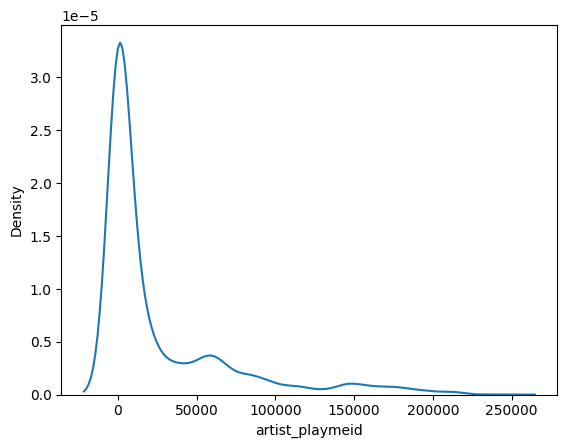

In [21]:
sns.kdeplot(data['artist_playmeid'])

### some artist have playmeid less then 1

In [22]:
data[data['artist_playmeid'] < 0]

,bar_confidence,bar_start,beat_confidence,beat_start,sections_confidence,sections_start,segments_confidence,segments_loudness_max,segments_loudness_max_time,segments_loudness_start,...,artist_longitude,artist_mbid,artist_name,artist_playmeid,release,release_7digitalid,song_hotttnesss,song_id,title,track_7digitalid
6,"[0.709, 0.641, 0.531, 0.542, 0.47, 0.049, 0.57...","[0.27253, 0.70535, 1.13191, 1.53913, 1.94418, ...","[0.709, 0.641, 0.531, 0.542, 0.47, 0.049, 0.57...","[0.27253, 0.70535, 1.13191, 1.53913, 1.94418, ...","[1.0, 0.338, 0.477, 0.862]","[0.0, 10.6519, 54.27073, 93.68212]","[0.0, 1.0, 1.0, 1.0, 0.285, 1.0, 0.034, 0.734,...","[-55.508, -10.928, -27.764, -14.137, -14.675, ...","[0.07564, 0.05985, 0.03653, 0.07117, 0.07724, ...","[-60.0, -55.786, -55.547, -45.022, -19.357, -3...",...,NaN,56503d6d-094e-4c28-ae3d-04cc748ade5b,Rated R,-1,Da Ghetto Psychic,25824,NaN,SOMJBYD12A6D4F8557,Keepin It Real (Skit),276593
7,"[0.142, 0.2, 0.358, 0.321, 0.017, 0.138, 0.124...","[0.65428, 2.42697, 4.21143, 5.98706, 7.74357, ...","[0.234, 0.31, 0.217, 0.026, 0.018, 0.02, 0.176...","[0.65428, 1.24174, 1.83362, 2.42697, 3.02032, ...","[1.0, 0.749, 0.416, 0.667, 0.055, 0.661, 0.298...","[0.0, 15.99351, 40.50153, 57.1495, 72.05522, 9...","[0.0, 0.011, 0.427, 0.77, 0.233, 1.0, 0.03, 0....","[-59.479, -57.932, -52.588, -43.102, -41.532, ...","[0.30442, 0.08504, 0.44208, 0.21509, 0.0159, 0...","[-60.0, -59.5, -57.988, -52.612, -43.199, -53....",...,NaN,d89de379-665d-425c-b2e9-41b95d1edb36,Tweeterfriendly Music,-1,Gin & Phonic,8876,NaN,SOHKNRJ12A6701D1F8,Drop of Rain,90004
8,"[0.806, 0.384, 0.868, 0.601, 0.509, 0.753, 0.3...","[1.91886, 4.69392, 7.46235, 10.22307, 12.98979...","[0.44, 0.0, 0.253, 0.418, 0.227, 0.0, 0.107, 0...","[1.22595, 1.91886, 2.6098, 3.30422, 3.9995, 4....","[1.0, 0.946, 0.222, 0.558, 0.062, 0.126, 0.026...","[0.0, 8.84703, 45.16366, 100.4712, 119.31833, ...","[0.0, 0.135, 0.252, 0.215, 0.015, 0.245, 0.072...","[-56.079, -55.018, -53.516, -52.784, -52.486, ...","[1.22157, 0.05528, 0.24208, 0.06153, 0.07085, ...","[-60.0, -57.277, -56.676, -55.359, -53.96, -54...",...,NaN,19d232b9-b4d7-4dc8-b259-bf65efb655b1,Planet P Project,-1,Pink World,358182,0.265861,SOIAZJW12AB01853F1,Pink World,3996579
9,"[0.047, 0.007, 0.615, 0.741, 0.454, 0.124, 0.3...","[0.62445, 2.73661, 4.83785, 6.94481, 9.04649, ...","[1.0, 1.0, 1.0, 0.944, 1.0, 1.0, 0.947, 1.0, 0...","[0.09933, 0.62445, 1.15423, 1.68069, 2.20947, ...","[1.0, 0.591, 0.475, 0.857, 0.717, 0.714, 0.664...","[0.0, 19.57644, 60.10462, 77.47084, 95.36334, ...","[0.0, 1.0, 0.783, 1.0, 0.776, 1.0, 0.688, 0.79...","[-60.0, -7.309, -17.716, -6.95, -17.942, -13.3...","[0.0, 0.02321, 0.02379, 0.02684, 0.02428, 0.04...","[-60.0, -60.0, -29.164, -40.09, -29.312, -31.9...",...,NaN,4d96f7d0-2f0e-4e92-ba70-a405f96f8cec,Clp,-1,Superinstrumental,692313,NaN,SOUDSGM12AC9618304,Insatiable (Instrumental Version),7684249
10,"[0.873, 0.47, 0.455, 0.43, 0.62, 0.53, 0.658, ...","[0.11194, 0.52532, 0.9377, 1.35107, 1.76545, 2...","[0.873, 0.47, 0.455, 0.43, 0.62, 0.53, 0.658, ...","[0.11194, 0.52532, 0.9377, 1.35107, 1.76545, 2...","[1.0, 1.0, 0.08, 0.691, 0.512, 0.695, 0.481, 0...","[0.0, 8.01012, 38.301, 63.68611, 73.07709, 96....","[0.334, 0.95, 0.42, 0.355, 0.346, 0.294, 0.1, ...","[-56.905, -38.256, -34.39, -31.889, -29.632, -...","[0.12212, 0.22936, 0.10574, 0.07403, 0.11791, ...","[-60.0, -59.052, -38.033, -35.542, -33.17, -30...",...,-80.01955,eb722df4-372e-4742-8586-f7ff658012d6,JennyAnyKind,-1,I Need You,539081,0.000000,SOQHXMF12AB0182363,Young Boy Blues,5967937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8805,"[0.327, 0.494, 0.076, 0.138, 0.017, 0.209, 0.0...","[1.05264, 2.97389, 4.88314, 6.79496, 8.85285, ...","[1.0, 0.267, 0.571, 0.552, 0.484, 0.652, 0.653...","[0.09674, 0.57423, 1.05264, 1.53198, 2.01131, ...","[1.0, 0.797, 0.237, 0.515, 0.597, 0.316, 0.463...","[0.0, 7.76338, 28.26208, 49.86806, 59.94315, 7...","[0.0, 1.0, 0.643, 1.0, 0.304, 0.23

### we can drop this column further

In [23]:
data['artist_longitude'].isna().sum()

5528

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8818 entries, 0 to 8817
Data columns (total 65 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   bar_confidence                  8818 non-null   object 
 1   bar_start                       8818 non-null   object 
 2   beat_confidence                 8818 non-null   object 
 3   beat_start                      8818 non-null   object 
 4   sections_confidence             8818 non-null   object 
 5   sections_start                  8818 non-null   object 
 6   segments_confidence             8818 non-null   object 
 7   segments_loudness_max           8818 non-null   object 
 8   segments_loudness_max_time      8818 non-null   object 
 9   segments_loudness_start         8818 non-null   object 
 10  segments_start                  8818 non-null   object 
 11  segments_timre                  8818 non-null   object 
 12  tatums_confidence               88

In [25]:
data['track_id'] = data['track_id'].apply(lambda x: x.decode('utf-8'))

<Axes: xlabel='tempo', ylabel='Density'>

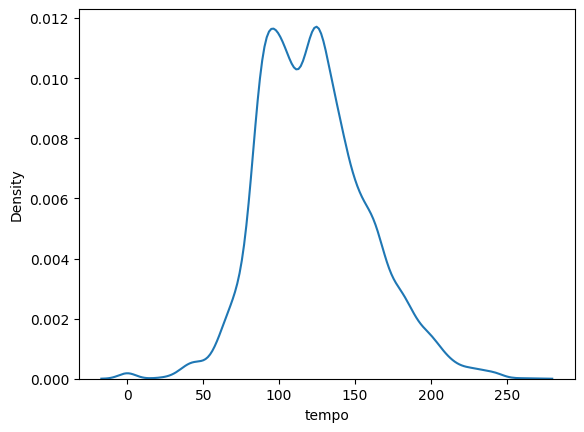

In [26]:
sns.kdeplot(data['tempo'])

<Axes: xlabel='duration', ylabel='Density'>

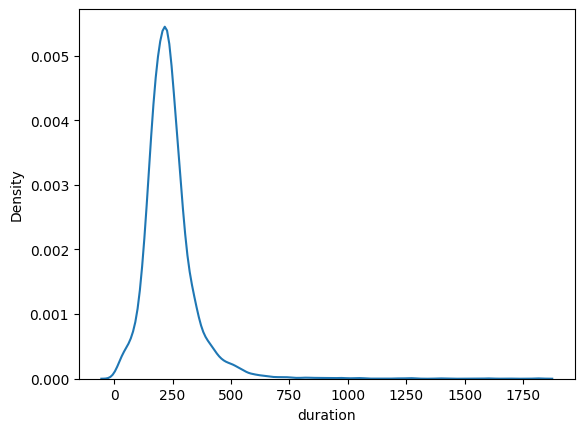

In [27]:
sns.kdeplot(data['duration'])

### some songs have very long durations extending beyound 20 mins

In [28]:
data[data['duration'] > 900]

,bar_confidence,bar_start,beat_confidence,beat_start,sections_confidence,sections_start,segments_confidence,segments_loudness_max,segments_loudness_max_time,segments_loudness_start,...,artist_longitude,artist_mbid,artist_name,artist_playmeid,release,release_7digitalid,song_hotttnesss,song_id,title,track_7digitalid
474,"[0.078, 0.066, 0.036, 0.072, 0.115, 0.196, 0.1...","[1.70869, 5.53556, 9.40663, 13.3713, 19.75239,...","[0.48, 0.419, 0.631, 0.559, 0.095, 0.598, 0.62...","[0.1629, 0.94078, 1.70869, 2.47227, 3.23409, 3...","[1.0, 0.621, 0.624, 0.718, 0.271, 0.514, 0.49,...","[0.0, 9.40663, 106.46909, 113.04035, 169.13267...","[0.0, 1.0, 1.0, 1.0, 0.919, 1.0, 0.614, 1.0, 1...","[-60.0, -31.877, -19.045, -31.543, -34.104, -1...","[0.0, 0.0879, 0.03394, 0.06121, 0.08057, 0.031...","[-60.0, -60.0, -43.373, -48.353, -46.084, -37....",...,-118.24532,9941a936-196a-4a62-ae53-a69cbc33f20e,Black Flag,6593,Everything Went Black,150242,0.499446,SOGJYZW12A8C134DBD,Crass Commercialism,1566526
994,"[0.196, 0.1, 0.226, 0.097, 0.429, 0.092, 0.157...","[6.60652, 8.58429, 10.55693, 12.58096, 14.5879...","[0.0, 0.269, 0.0, 0.0, 0.238, 0.0, 0.0, 0.244,...","[5.94783, 6.60652, 7.26178, 7.92903, 8.58429, ...","[1.0, 1.0, 0.399, 0.411, 0.431, 0.154, 0.027, ...","[0.0, 15.24662, 58.31858, 65.45963, 91.76238, ...","[0.0, 0.131, 0.282, 0.314, 0.293, 0.197, 0.372...","[-49.511, -46.5, -44.393, -45.079, -41.79, -40...","[5.73763, 0.66457, 1.16314, 0.07338, 0.31749, ...","[-60.0, -50.762, -51.36, -47.873, -45.134, -45...",...,-76.79731,24c0aaf3-4ac2-4f9a-9ce6-a1545a96f017,Kartik Seshadri,41952,Illuminations,254168,0.000000,SOBGEIG12A6D4F6635,Raga Anandi Kalyan (Alap_ jor and jhala),2815009
1090,"[0.09, 0.23, 0.25, 0.179, 0.1, 0.13, 0.209, 0....","[1.30825, 2.98996, 4.67168, 6.35906, 8.04502, ...","[0.501, 0.419, 0.373, 0.281, 0.224, 0.53, 0.23...","[0.17722, 0.74485, 1.30825, 1.86882, 2.42939, ...","[1.0, 0.151, 0.155, 0.39, 0.523, 0.176, 1.0, 0...","[0.0, 8.04502, 39.65672, 55.00771, 74.44049, 9...","[1.0, 1.0, 0.543, 0.708, 0.105, 0.973, 0.673, ...","[-29.678, -9.233, -14.04, -8.434, -16.345, -10...","[0.05286, 0.0964, 0.06433, 0.04892, 0.01595, 0...","[-48.606, -30.575, -19.722, -16.9, -20.187, -2...",...,NaN,,Mickey And The Students,-1,Some People,763388,0.000000,SOYSHBO12AB018CA41,Gimme Gimme Song,8452691
1145,"[0.279, 0.384, 0.846, 0.668, 0.479, 0.335, 0.0...","[1.37257, 3.18791, 4.70081, 6.19315, 7.79113, ...","[0.276, 0.375, 0.562, 0.281, 0.249, 0.392, 0.2...","[0.35225, 0.91512, 1.37257, 1.83786, 2.30316, ...","[1.0, 1.0, 0.926, 0.742, 0.821, 0.85, 0.766, 0...","[0.0, 15.2356, 58.63537, 75.9649, 85.8376, 109...","[1.0, 0.474, 0.204, 0.535, 0.304, 0.617, 0.178...","[-28.354, -28.606, -28.446, -27.006, -28.841, ...","[0.03942, 0.01951, 0.01514, 0.01949, 0.01727, ...","[-60.0, -33.936, -32.807, -33.719, -32.915, -3...",...,NaN,169c4c28-858e-497b-81a4-8bc15e0026ea,Porcupine Tree,9392,The Sky Moves Sideways (Special Edition),210456,0.812029,SOCDRKE12A8C13BF47,Moon Loop (Improvisation),2287242
1210,[],[],[],[],"[1.0, 0.094, 0.579, 0.263, 0.002, 0.284, 0.203...","[0.0, 5.47646, 18.77923, 29.25424, 56.55637, 1...","[0.0, 0.674, 0.376, 0.037, 1.0, 0.132, 0.213, ...","[-60.0, -52.902, -49.939, -48.326, -35.608, -4...","[0.0, 0.09343, 0.13694, 0.20775, 0.04534, 0.22...","[-60.0, -60.0, -53.092, -50.532, -48.519, -46....",...,NaN,48991947-18af-4327-9e4c-c8e8e7c113c3,Five Fingers of Funk,-1,About Time,230859,0.000000,SOHODRU12A81C230CE,Genuine,2530341
1499,"[0.274, 0.003, 0.078, 0.042, 0.043, 0.021, 0.1...","[0.43198, 1.33576, 2.31393, 3.29457, 4.27644, ...","[0.662, 0.655, 0.655, 0.442, 0.396, 0.378, 0.3...","[0.22491, 0.43198, 0.63904, 0.8399, 1.08228, 1...","[1.0, 0.111, 0.273, 0.588, 1.0, 1.0, 0.953, 0....","[0.0, 98.50166, 112.95202, 223.08351, 244.0135...","[0.0, 0.758, 0.187, 1.0, 0.922, 1.0, 0.964, 1....","[-60.0, -50.171, -52.774, -18.383, -27.76, -19...","[0.0, 0.18169, 0.11028, 0.02929, 0.02345, 0.02...","[-60.0, -60.0, -55.49, -56.75, -39.944, -56.0

<Axes: xlabel='start_of_fade_out', ylabel='Density'>

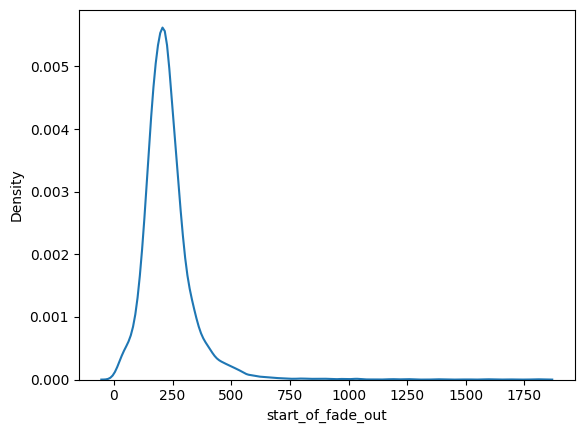

In [29]:
sns.kdeplot(data['start_of_fade_out'])

In [30]:
data[data['start_of_fade_out'] > 800]

,bar_confidence,bar_start,beat_confidence,beat_start,sections_confidence,sections_start,segments_confidence,segments_loudness_max,segments_loudness_max_time,segments_loudness_start,...,artist_longitude,artist_mbid,artist_name,artist_playmeid,release,release_7digitalid,song_hotttnesss,song_id,title,track_7digitalid
474,"[0.078, 0.066, 0.036, 0.072, 0.115, 0.196, 0.1...","[1.70869, 5.53556, 9.40663, 13.3713, 19.75239,...","[0.48, 0.419, 0.631, 0.559, 0.095, 0.598, 0.62...","[0.1629, 0.94078, 1.70869, 2.47227, 3.23409, 3...","[1.0, 0.621, 0.624, 0.718, 0.271, 0.514, 0.49,...","[0.0, 9.40663, 106.46909, 113.04035, 169.13267...","[0.0, 1.0, 1.0, 1.0, 0.919, 1.0, 0.614, 1.0, 1...","[-60.0, -31.877, -19.045, -31.543, -34.104, -1...","[0.0, 0.0879, 0.03394, 0.06121, 0.08057, 0.031...","[-60.0, -60.0, -43.373, -48.353, -46.084, -37....",...,-118.24532,9941a936-196a-4a62-ae53-a69cbc33f20e,Black Flag,6593,Everything Went Black,150242,0.499446,SOGJYZW12A8C134DBD,Crass Commercialism,1566526
994,"[0.196, 0.1, 0.226, 0.097, 0.429, 0.092, 0.157...","[6.60652, 8.58429, 10.55693, 12.58096, 14.5879...","[0.0, 0.269, 0.0, 0.0, 0.238, 0.0, 0.0, 0.244,...","[5.94783, 6.60652, 7.26178, 7.92903, 8.58429, ...","[1.0, 1.0, 0.399, 0.411, 0.431, 0.154, 0.027, ...","[0.0, 15.24662, 58.31858, 65.45963, 91.76238, ...","[0.0, 0.131, 0.282, 0.314, 0.293, 0.197, 0.372...","[-49.511, -46.5, -44.393, -45.079, -41.79, -40...","[5.73763, 0.66457, 1.16314, 0.07338, 0.31749, ...","[-60.0, -50.762, -51.36, -47.873, -45.134, -45...",...,-76.79731,24c0aaf3-4ac2-4f9a-9ce6-a1545a96f017,Kartik Seshadri,41952,Illuminations,254168,0.000000,SOBGEIG12A6D4F6635,Raga Anandi Kalyan (Alap_ jor and jhala),2815009
1090,"[0.09, 0.23, 0.25, 0.179, 0.1, 0.13, 0.209, 0....","[1.30825, 2.98996, 4.67168, 6.35906, 8.04502, ...","[0.501, 0.419, 0.373, 0.281, 0.224, 0.53, 0.23...","[0.17722, 0.74485, 1.30825, 1.86882, 2.42939, ...","[1.0, 0.151, 0.155, 0.39, 0.523, 0.176, 1.0, 0...","[0.0, 8.04502, 39.65672, 55.00771, 74.44049, 9...","[1.0, 1.0, 0.543, 0.708, 0.105, 0.973, 0.673, ...","[-29.678, -9.233, -14.04, -8.434, -16.345, -10...","[0.05286, 0.0964, 0.06433, 0.04892, 0.01595, 0...","[-48.606, -30.575, -19.722, -16.9, -20.187, -2...",...,NaN,,Mickey And The Students,-1,Some People,763388,0.000000,SOYSHBO12AB018CA41,Gimme Gimme Song,8452691
1145,"[0.279, 0.384, 0.846, 0.668, 0.479, 0.335, 0.0...","[1.37257, 3.18791, 4.70081, 6.19315, 7.79113, ...","[0.276, 0.375, 0.562, 0.281, 0.249, 0.392, 0.2...","[0.35225, 0.91512, 1.37257, 1.83786, 2.30316, ...","[1.0, 1.0, 0.926, 0.742, 0.821, 0.85, 0.766, 0...","[0.0, 15.2356, 58.63537, 75.9649, 85.8376, 109...","[1.0, 0.474, 0.204, 0.535, 0.304, 0.617, 0.178...","[-28.354, -28.606, -28.446, -27.006, -28.841, ...","[0.03942, 0.01951, 0.01514, 0.01949, 0.01727, ...","[-60.0, -33.936, -32.807, -33.719, -32.915, -3...",...,NaN,169c4c28-858e-497b-81a4-8bc15e0026ea,Porcupine Tree,9392,The Sky Moves Sideways (Special Edition),210456,0.812029,SOCDRKE12A8C13BF47,Moon Loop (Improvisation),2287242
1210,[],[],[],[],"[1.0, 0.094, 0.579, 0.263, 0.002, 0.284, 0.203...","[0.0, 5.47646, 18.77923, 29.25424, 56.55637, 1...","[0.0, 0.674, 0.376, 0.037, 1.0, 0.132, 0.213, ...","[-60.0, -52.902, -49.939, -48.326, -35.608, -4...","[0.0, 0.09343, 0.13694, 0.20775, 0.04534, 0.22...","[-60.0, -60.0, -53.092, -50.532, -48.519, -46....",...,NaN,48991947-18af-4327-9e4c-c8e8e7c113c3,Five Fingers of Funk,-1,About Time,230859,0.000000,SOHODRU12A81C230CE,Genuine,2530341
1499,"[0.274, 0.003, 0.078, 0.042, 0.043, 0.021, 0.1...","[0.43198, 1.33576, 2.31393, 3.29457, 4.27644, ...","[0.662, 0.655, 0.655, 0.442, 0.396, 0.378, 0.3...","[0.22491, 0.43198, 0.63904, 0.8399, 1.08228, 1...","[1.0, 0.111, 0.273, 0.588, 1.0, 1.0, 0.953, 0....","[0.0, 98.50166, 112.95202, 223.08351, 244.0135...","[0.0, 0.758, 0.187, 1.0, 0.922, 1.0, 0.964, 1....","[-60.0, -50.171, -52.774, -18.383, -27.76, -19...","[0.0, 0.18169, 0.11028, 0.02929, 0.02345, 0.02...","[-60.0, -60.0, -55.49, -56.75, -39.944, -56.0

<Axes: xlabel='loudness', ylabel='Density'>

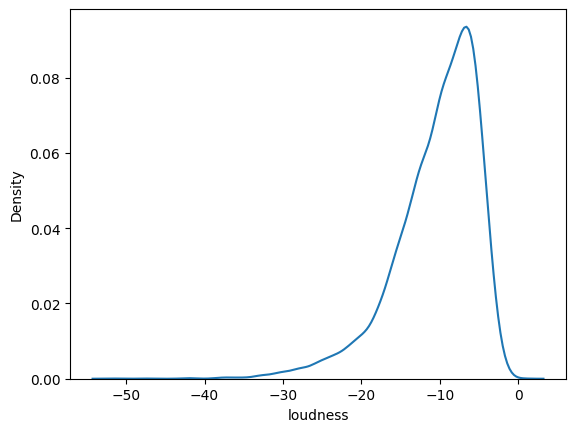

In [31]:
sns.kdeplot(data['loudness'])

In [32]:
data['artist_terms_list']

,artist_terms_list
0,"[hip hop, underground rap, g funk, alternative..."
1,"[blue-eyed soul, pop rock, blues-rock, beach m..."
2,"[salsa, cumbia, tejano, ranchera, latin pop, l..."
3,"[pop rock, new wave, dance rock, rock, new rom..."
4,"[pop punk, ska punk, breakcore, alternative me..."
...,...
8813,"[chinese music, cantonese pop, ballad, nu jazz..."
8814,"[brill building pop, all-female, motown, rock ..."
8815,"[comedy, grindcore, germany, german, stand-up ..."
8816,"[pop, indie, alternative, french pop, soundtra..."


In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8818 entries, 0 to 8817
Data columns (total 65 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   bar_confidence                  8818 non-null   object 
 1   bar_start                       8818 non-null   object 
 2   beat_confidence                 8818 non-null   object 
 3   beat_start                      8818 non-null   object 
 4   sections_confidence             8818 non-null   object 
 5   sections_start                  8818 non-null   object 
 6   segments_confidence             8818 non-null   object 
 7   segments_loudness_max           8818 non-null   object 
 8   segments_loudness_max_time      8818 non-null   object 
 9   segments_loudness_start         8818 non-null   object 
 10  segments_start                  8818 non-null   object 
 11  segments_timre                  8818 non-null   object 
 12  tatums_confidence               88

### further changes required

In [34]:
data['artist_mbtags'] = data['artist_mbtags'].apply(lambda x: ["Unknown"] if len(x) == 0 else [item.decode('utf-8') for item in x])

### run this code again one more time

In [35]:
data['artist_mbtags_counts'] = data['artist_mbtags_counts'].apply(lambda x: [0] if len(x) == 0 else x)

In [36]:
data['artist_mbtags_counts']

,artist_mbtags_counts
0,[0]
1,[1]
2,[0]
3,"[1, 1, 1]"
4,[0]
...,...
8813,"[1, 1, 1, 1]"
8814,"[1, 1, 1, 1]"
8815,"[2, 1]"
8816,"[1, 1, 1]"


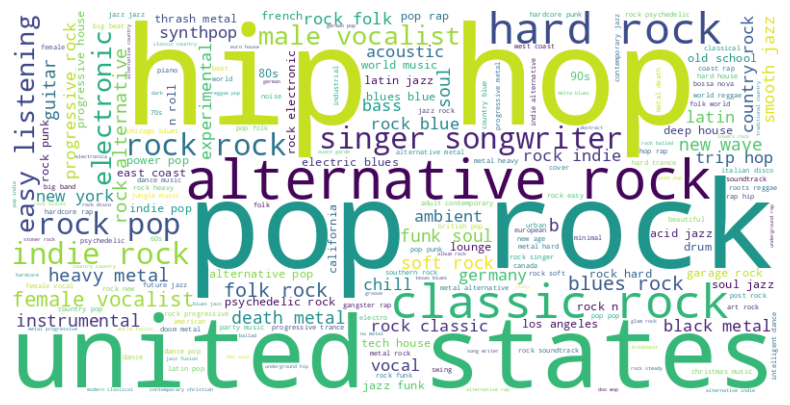

In [37]:
artist_tags_list = []
for i in data['artist_terms_list']:
  for j in i:
    artist_tags_list.append(j)

tag_text = ' '.join(artist_tags_list)
wordcloud = WordCloud(width = 800, height = 400, background_color = 'white').generate(tag_text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [38]:
data[data['beat_confidence'].apply(lambda x: len(x)) == 0]

,bar_confidence,bar_start,beat_confidence,beat_start,sections_confidence,sections_start,segments_confidence,segments_loudness_max,segments_loudness_max_time,segments_loudness_start,...,artist_longitude,artist_mbid,artist_name,artist_playmeid,release,release_7digitalid,song_hotttnesss,song_id,title,track_7digitalid
276,[],[],[],[],"[1.0, 0.234, 0.069, 0.063, 0.033]","[0.0, 46.80033, 71.78241, 95.12842, 109.00023]","[0.0, 0.24, 1.0, 0.406, 0.172, 0.054, 0.196, 0...","[-60.0, -56.863, -30.898, -28.09, -25.144, -24...","[0.0, 0.10561, 0.24456, 0.27467, 0.14313, 0.04...","[-60.0, -60.0, -56.947, -34.066, -29.5, -27.06...",...,0.48883,1ab5ec20-743e-4f11-9c37-237f190ae447,Frank Chacksfield,158461,Windsor Strings,582102,NaN,SOGBJSK12AB018D052,Someone to Watch Over Me,6451876
300,[],[],[],[],"[1.0, 0.283, 0.231, 0.032, 0.13]","[0.0, 62.56966, 78.79566, 134.55146, 147.19352]","[0.511, 0.896, 0.062, 0.407, 0.528, 0.031, 0.0...","[-52.353, -44.634, -43.192, -41.048, -41.984, ...","[0.28444, 0.40943, 0.23379, 0.01996, 0.05287, ...","[-60.0, -58.163, -47.205, -43.482, -47.808, -4...",...,-74.72671,02ea73c9-a5f0-4b63-91f1-c97fa27567ff,The American Boychoir,182287,Voices of Angles - Christmas Favorites from th...,79227,NaN,SOITEVV12A6D4F5969,Stille nacht_ heilige nacht,834796
728,[],[],[],[],"[1.0, 1.0, 0.389, 0.783, 0.726, 0.073, 0.002, ...","[0.0, 19.94308, 55.82531, 128.0498, 143.50227,...","[0.0, 1.0, 0.498, 0.645, 0.825, 0.141, 0.49, 0...","[-60.0, -14.893, -18.446, -11.844, -13.97, -12...","[0.0, 0.12136, 0.11936, 0.07859, 0.22367, 0.04...","[-60.0, -60.0, -24.421, -18.752, -26.393, -14....",...,NaN,b8282669-ab13-40c2-a01e-acbb9cf64981,liquid soul & freq,139978,extrasensory perception compiled by martin & L...,388984,0.000000,SOFWMDO12A8C135956,Liquid Frequencies (liquid Soul Mix),4313631
1210,[],[],[],[],"[1.0, 0.094, 0.579, 0.263, 0.002, 0.284, 0.203...","[0.0, 5.47646, 18.77923, 29.25424, 56.55637, 1...","[0.0, 0.674, 0.376, 0.037, 1.0, 0.132, 0.213, ...","[-60.0, -52.902, -49.939, -48.326, -35.608, -4...","[0.0, 0.09343, 0.13694, 0.20775, 0.04534, 0.22...","[-60.0, -60.0, -53.092, -50.532, -48.519, -46....",...,NaN,48991947-18af-4327-9e4c-c8e8e7c113c3,Five Fingers of Funk,-1,About Time,230859,0.000000,SOHODRU12A81C230CE,Genuine,2530341
1458,[],[],[],[],"[1.0, 0.096, 0.275, 0.349, 0.384, 0.379, 0.273...","[0.0, 17.61109, 40.37686, 49.47784, 61.4108, 7...","[0.0, 0.172, 0.32, 0.296, 0.611, 0.286, 0.21, ...","[-60.0, -57.62, -54.16, -51.367, -44.507, -41....","[0.0, 0.09766, 0.0997, 0.16213, 0.19226, 0.034...","[-60.0, -60.0, -57.655, -54.327, -51.387, -44....",...,NaN,afb8d624-52d7-4a72-8d0b-62fff3e29f79,Sir Neville Marriner,61257,Respighi: Ancient Airs and Dances,148194,NaN,SOOZPUG12A8C132EDD,Ancient Airs and Dances (1996 Digital Remaster...,1542943
1541,[],[],[],[],[],[],"[1.0, 0.352, 0.118, 0.215, 0.455, 0.332, 0.382...","[-39.025, -35.864, -35.303, -34.54, -33.33, -3...","[0.1295, 0.10729, 0.05238, 0.11071, 0.1516, 0....","[-58.564, -40.138, -37.618, -37.106, -38.973, ...",...,NaN,7463fbd2-60fb-471a-a5cd-d42b75d72dad,Bare Jr.,23520,Boo-Tay,282150,NaN,SOWHXYS12AC9E177F0,Snippet 15,3139149
1859,[],[],[],[],"[1.0, 1.0, 0.514, 0.548, 0.747, 1.0, 0.211, 0....","[0.0, 7.9034, 23.85873, 41.51442, 55.30862, 75...","[1.0, 0.286, 1.0, 0.975, 1.0, 1.0, 1.0, 1.0, 0...","[-28.275, -53.59, -24.689, -22.63, -27.659, -2...","[0.46645, 0.04488, 0.02272, 0.019, 0.02415, 0....","[-60.0, -56.537, -55.875, -43.845, -53.509, -4...",...,-58.37354,cfe85625-10af-46c1-99fb-765ed3a4f1ad,Los Fabulosos Cadillacs,15034,Bares y Fondas,346407,0.434838,SOSPNDI12AB017F769,Noches Arabes,3884134
2427,[],[],[],[],"[1.0, 0.523, 0.866, 0.346, 0.768, 0.476, 1.0, ...","[0.0, 6.70522, 66.06984, 131.87968, 147.49474,...","[0.0, 1.0, 0.17, 1.0, 0.714, 0.884, 1.0, 0.978...","[-60.0, -18.476, -25.01, -9.863, -9.643, -10.6...","[0.0, 0.02421, 0.02214, 0.02885, 0.0199, 0.020...","[-60.0, -60.0, -30.293, -29.913, -23.834, -26....",...,-0.12714,3ab20833-bea6-4972-9e83-14599e3666a

In [39]:
data = data[data['beat_start'].apply(lambda x: len(x)) > 0]
data = data[data['beat_confidence'].apply(lambda x: len(x)) > 0]
data = data[data['beat_confidence'].apply(lambda x: len(x)) > 0]
data = data[data['bar_confidence'].apply(lambda x: len(x)) > 0]
data = data[data['sections_confidence'].apply(lambda x: len(x)) > 0]
data = data[data['tatums_start'].apply(lambda x: len(x)) > 0]

In [40]:
mean_data = data[['bar_confidence', 'beat_confidence', 'loudness']]

In [41]:
for i in mean_data.columns[:-1]:
  mean_data[i + '_mean'] = mean_data[i].apply(lambda x: np.mean(x))

<ipython-input-41-43db8310e8dc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_data[i + '_mean'] = mean_data[i].apply(lambda x: np.mean(x))
<ipython-input-41-43db8310e8dc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_data[i + '_mean'] = mean_data[i].apply(lambda x: np.mean(x))


In [42]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

In [43]:
scaler = StandardScaler()

In [44]:
scaled_features = scaler.fit_transform(mean_data[['loudness', 'bar_confidence_mean', 'beat_confidence_mean',
       ]])

In [45]:
similarity_matix = cosine_similarity(scaled_features[:10])

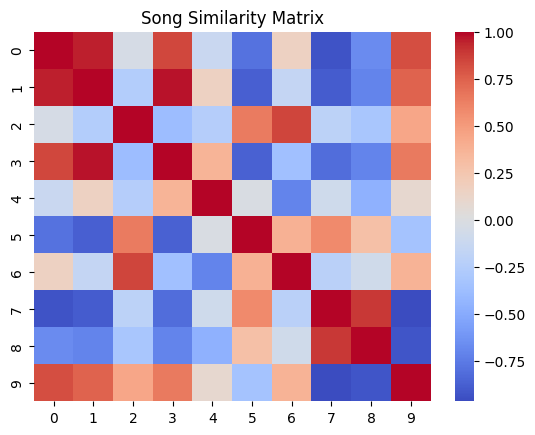

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.heatmap(similarity_matix, cmap="coolwarm")
plt.title("Song Similarity Matrix")
plt.show()


In [47]:
data.head()

,bar_confidence,bar_start,beat_confidence,beat_start,sections_confidence,sections_start,segments_confidence,segments_loudness_max,segments_loudness_max_time,segments_loudness_start,...,artist_longitude,artist_mbid,artist_name,artist_playmeid,release,release_7digitalid,song_hotttnesss,song_id,title,track_7digitalid
0,"[0.643, 0.746, 0.722, 0.095, 0.091, 0.362, 0.4...","[0.58521, 2.94247, 5.14371, 7.74554, 10.36149,...","[0.834, 0.851, 0.65, 0.635, 0.532, 0.753, 0.62...","[0.58521, 1.19196, 1.78893, 2.37813, 2.94247, ...","[1.0, 1.0, 0.218, 0.133, 0.384, 0.326, 0.373, ...","[0.0, 7.74554, 36.44331, 43.61667, 75.17954, 9...","[0.0, 1.0, 0.483, 0.137, 0.42, 1.0, 0.257, 1.0...","[-60.0, -31.646, -34.565, -38.407, -34.696, -2...","[0.0, 0.10929, 0.11044, 0.0844, 0.05898, 0.073...","[-60.0, -60.0, -40.84, -40.401, -38.456, -39.6...",...,NaN,e77e51a5-4761-45b3-9847-2051f811e366,Casual,4479,Fear Itself,300848,0.602120,SOMZWCG12A8C13C480,I Didn't Mean To,3401791
1,"[0.007, 0.259, 0.172, 0.404, 0.011, 0.016, 0.0...","[0.71054, 2.71502, 4.70861, 6.69288, 8.66941, ...","[1.0, 0.945, 0.714, 0.973, 0.818, 0.974, 0.878...","[0.20627, 0.71054, 1.21836, 1.71841, 2.21729, ...","[1.0, 0.451, 0.27, 0.397, 0.225, 0.426, 0.459,...","[0.0, 8.1777, 19.52952, 38.84063, 50.22563, 70...","[0.0, 1.0, 0.93, 0.643, 0.761, 0.21, 1.0, 0.71...","[-60.0, -14.269, -10.165, -18.098, -19.136, -1...","[0.0, 0.05811, 0.03982, 0.04186, 0.03568, 0.03...","[-60.0, -60.0, -23.521, -25.16, -27.133, -24.2...",...,-90.04892,1c78ab62-db33-4433-8d0b-7c8dcf1849c2,The Box Tops,22066,Dimensions,300822,NaN,SOCIWDW12A8C13D406,Soul Deep,3400270
2,"[0.98, 0.399, 0.185, 0.27, 0.422, 0.0, 0.445, ...","[0.73152, 1.39732, 2.04852, 2.68691, 3.315, 3....","[0.98, 0.399, 0.185, 0.27, 0.422, 0.0, 0.445, ...","[0.73152, 1.39732, 2.04852, 2.68691, 3.315, 3....","[1.0, 0.121, 0.214, 0.198, 0.66, 0.468, 0.591,...","[0.0, 37.88678, 49.43939, 68.63657, 98.89331, ...","[0.0, 1.0, 0.106, 0.048, 0.282, 0.69, 0.308, 0...","[-59.895, -11.914, -10.344, -9.678, -9.22, -8....","[0.27572, 0.1589, 0.0515, 0.0741, 0.09185, 0.0...","[-60.0, -59.9, -12.744, -12.003, -12.991, -15....",...,NaN,7a273984-edd9-4451-9c4d-39b38f05ebcd,Sonora Santanera,13951,Las Numero 1 De La Sonora Santanera,514953,NaN,SOXVLOJ12AB0189215,Amor De Cabaret,5703798
3,"[0.017, 0.05, 0.014, 0.008, 0.114, 0.019, 0.08...","[1.30621, 3.29887, 5.30252, 7.32327, 9.33775, ...","[0.809, 0.616, 0.789, 0.66, 0.439, 0.758, 0.60...","[0.81002, 1.30621, 1.80617, 2.2996, 2.80049, 3...","[1.0, 0.086, 0.153, 0.146, 0.088, 0.217, 0.372...","[0.0, 20.38681, 27.94943, 55.12454, 67.71832, ...","[1.0, 1.0, 0.919, 0.591, 0.841, 0.174, 0.753, ...","[-18.682, -9.55, -9.709, -8.633, -7.434, -11.7...","[0.34385, 0.07741, 0.04658, 0.07981, 0.04477, ...","[-60.0, -27.665, -21.241, -15.222, -18.915, -1...",...,NaN,e188a520-9cb7-4f73-a3d7-2f70c6538e92,Adam Ant,12697,Friend Or Foe,287650,NaN,SONHOTT12A8C13493C,Something Girls,3226795
4,"[0.175, 0.409, 0.639, 0.067, 0.016, 0.066, 0.0...","[1.06368, 2.91491, 4.76729, 6.61852, 8.46978, ...","[0.883, 0.738, 0.484, 0.609, 0.625, 0.719, 0.4...","[0.13576, 0.59914, 1.06368, 1.52591, 1.99045, ...","[1.0, 0.768, 0.611, 0.388, 0.52, 0.42, 0.499, ...","[0.0, 8.00636, 23.26694, 67.22425, 74.15257, 1...","[0.0, 1.0, 0.359, 1.0, 0.963, 0.544, 1.0, 0.75...","[-59.813, -7.713, -16.13, -2.512, -8.088, -8.7...","[0.06094, 0.06433, 0.02255, 0.02018, 0.02463, ...","[-60.0, -59.828, -19.551, -32.609, -21.899, -2...",...,NaN,c6903a2e-063c-4f91-a284-17b8f421be7b,Gob,8355,Muertos Vivos,611336,0.604501,SOFSOCN12A8C143F5D,Face the Ashes,6795666


In [48]:
data.size

569725

In [49]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define the columns to process
feature_columns = ["bar_confidence", "beat_confidence", "sections_confidence"]

df = data[feature_columns]

print(df.size)

# Parse and pad features
def parse_and_pad(column, pad_length):
    sequences = df[column].tolist()  # Convert string to list
    return pad_sequences(sequences, maxlen=pad_length, padding='post', dtype='float32')

# Define padding length (adjust based on your dataset)
pad_length = 20  # Choose an appropriate sequence length

# Process each feature column
features = [parse_and_pad(col, pad_length) for col in feature_columns]

# Combine features into a single tensor
X = np.stack(features, axis=0)  # Shape: (n_samples, n_features, sequence_length)
print(X.shape)
X = X[..., np.newaxis]  # Add channel dimension for CNN: (n_samples, n_features, sequence_length, 1)

print("Input shape:", X.shape)


26295
(3, 8765, 20)
Input shape: (3, 8765, 20, 1)


In [50]:
X = np.moveaxis(X, 0, 1)  # Move axis 0 to position 1, reshaping to (n_samples, n_features, sequence_length, 1)

# Check the reshaped input
print("Reshaped input shape:", X.shape)

Reshaped input shape: (8765, 3, 20, 1)


In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Model definition
n_features, sequence_length = X.shape[1:3]
embedding_size = 50

model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(n_features, sequence_length, 1), padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(embedding_size)  # Embedding layer
])

model.compile(optimizer='adam', loss='mse')

# Dummy target for training (replace with real labels or unsupervised task)
y = np.random.rand(X.shape[0], embedding_size).astype(np.float32)

# Train the model
model.fit(X, y, epochs=20, batch_size=32)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1271
Epoch 2/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0843
Epoch 3/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0837
Epoch 4/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0837
Epoch 5/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0837
Epoch 6/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0838
Epoch 7/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0837
Epoch 8/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0836
Epoch 9/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0835
Epoch 10/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0835
Epoch 11/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0832
Epoch 12/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0835
Epoch 13/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0833
Epoch 14/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0833
Epoch 15/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - lo

In [52]:
# Generate embeddings
embeddings = model.predict(np.transpose(X, (0, 2, 1, 3)))


print("Embeddings shape:", embeddings.shape)  # Shape: (n_samples, embedding_size)


274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Embeddings shape: (8765, 50)


In [53]:
model.save('song_embedding_model.keras')

In [54]:
# Save embeddings to a CSV
embedding_df = pd.DataFrame(embeddings)
embedding_df.to_csv("song_embeddings.csv", index=False)

In [55]:
len(embeddings)

8765

In [56]:
len(data)

8765

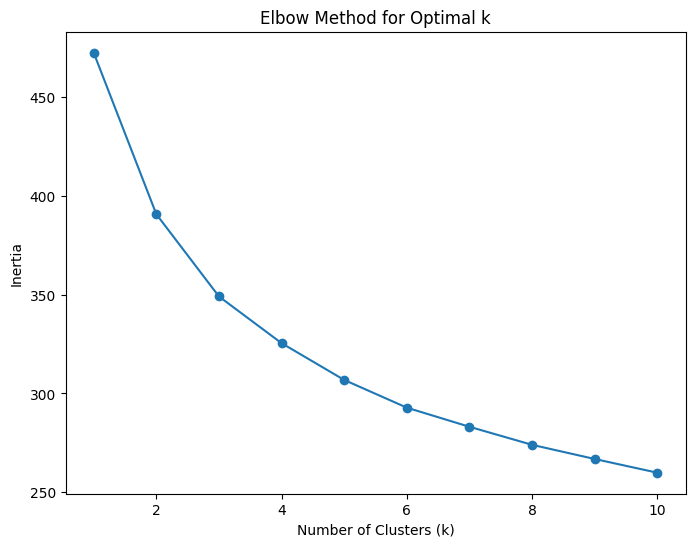

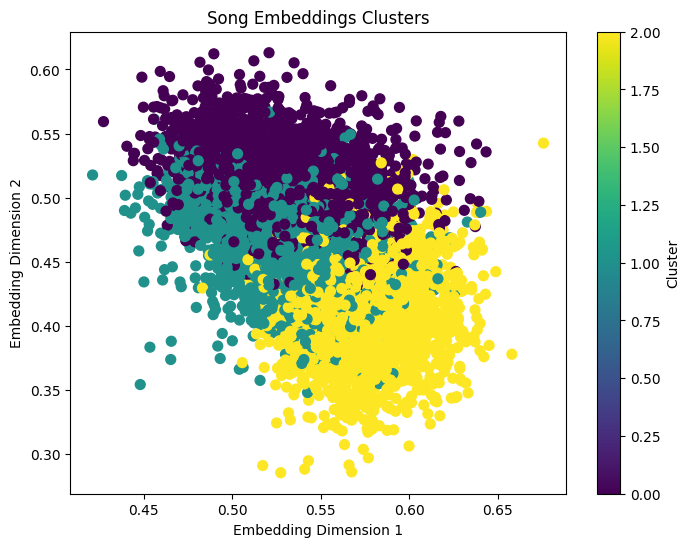

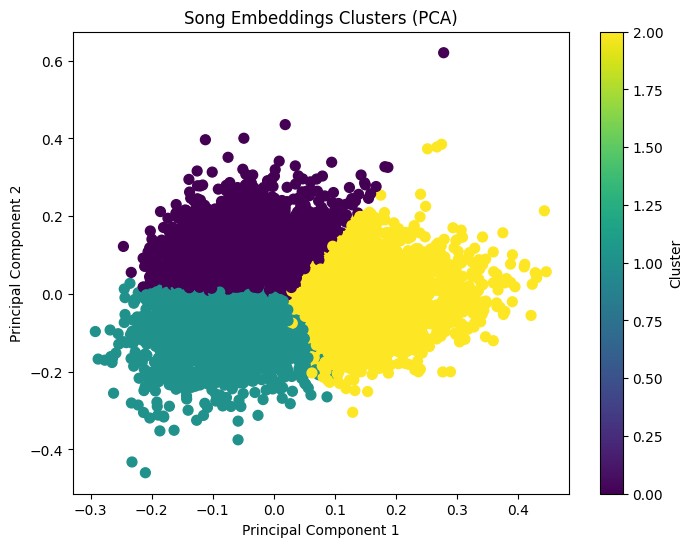

In [57]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Load the embeddings
embeddings = pd.read_csv("song_embeddings.csv").values

# Determine the optimal number of clusters using the Elbow method
inertia = []
for k in range(1, 11):  # Test k values from 1 to 10
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)  # Increased n_init for better results
    kmeans.fit(embeddings)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

# Based on the elbow method, choose the optimal k (e.g., k=3)
k = 3  # Replace with the optimal k from the elbow plot
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
clusters = kmeans.fit_predict(embeddings)

# Example plot if embedding is 2-dimensional
plt.figure(figsize=(8, 6))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=clusters, cmap='viridis', s=50)
plt.title('Song Embeddings Clusters')
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')
plt.colorbar(label='Cluster')
plt.show()


from sklearn.decomposition import PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions
embeddings_2d = pca.fit_transform(embeddings)
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=clusters, cmap='viridis', s=50)
plt.title('Song Embeddings Clusters (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()



In [58]:
from sklearn.metrics import silhouette_score

# Calculate the silhouette score
silhouette_avg = silhouette_score(embeddings, clusters)

print(f"The average silhouette score is: {silhouette_avg}")

The average silhouette score is: 0.13626673789067173


In [60]:
# Assuming 'clusters' and 'data' are defined from the previous code
# and 'embeddings' is loaded

# Create a DataFrame with song titles and cluster assignments
song_clusters = pd.DataFrame({'title': data['title'], 'cluster': clusters})

# Print 5 random song names from each cluster
for cluster_id in range(k):  # Iterate through each cluster
    cluster_songs = song_clusters[song_clusters['cluster'] == cluster_id]
    print(f"Cluster {cluster_id}:")

    # Handle cases where a cluster might have fewer than 5 songs
    num_songs_to_print = min(10, len(cluster_songs))

    random_songs = cluster_songs.sample(n=num_songs_to_print, random_state=0) # Set random_state for reproducibility
    for index, row in random_songs.iterrows():
        print(row['title'])
    print("\n")

Cluster 0:
Loud And Clear
Boss-Eyed Whelk
Summer Summer
Separate Ways
Body
Freiwild
El Gatito
Just A Phase
What If I Kissed You Right Now?
Bewitched_ Bothered & Bewildered


Cluster 1:
Baby My Love
Focus
Chim Chim Cheree
Girls Against Boys (LP Version)
Saturday Night Special
The Three-Dimensional Shadow
I Wanna Sing (Autobiography Album Version)
Dedicado
Where in the World
Una dolce melodia


Cluster 2:
I've Won (Introduction - Speaking)
The Big Stall
Container
Money Blues
Style
High On the Mountain
We Will Glorify (Key-B-Db-Premiere Performance Plus)
Poaki
Poppin' Them Thangs
Think About Me


